In [1]:
import sys, os

sys.path.append(os.path.abspath("forStudents"))
sys.path.append(os.path.abspath("Images"))

In [2]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline

In [3]:
from scipy.io import wavfile

In [4]:
dataset = wavfile.read("forStudents/timit/train/dr1/fdaw0/sa1.wav")

In [5]:
dataset[1].shape

(53556,)

In [6]:
y = dataset[1]
x = np.linspace(0, y.shape[0], y.shape[0])

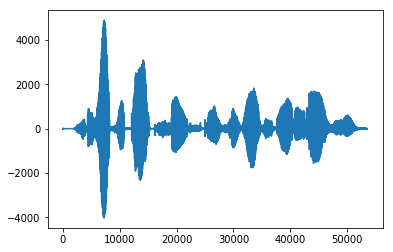

In [7]:
plt.plot(x, y)

### Task 1: Frame Segmentation
- Audio data: divided into frames of length $t_{frame}=20ms$ with feed $t_{feed}=10ms$ between 2 neighboring frames:
<img src='Images/speaker/1_frame_segmentation.JPG' width='400'>
- where $f_s$: sample frequency = dataset[0] = 16000 = 16kHz
- So, each frame will contain 16000 * 20ms = 320 samples.
<img src='Images/speaker/2_frame_segmentation.JPG' width='300'>
- As the above figure, we have the offset which is defined by $t_{feed} * f_s = 10ms * 16000 = 160$

In [8]:
# Implement frame segmentation:
import math # For python 3.x, for python 2.x, use int
def frame_segment(full_frame, frame_length=320, offset=160):
    no_samples = full_frame.shape[0]
    no_frames = math.floor((no_samples - frame_length) / offset + 1)
    frame_matrix = np.empty([no_frames, frame_length])
    for k in range(0, no_frames):
        start = k * offset
        end = start + frame_length
        frame = full_frame[start:end]
        frame_matrix[k, ] = frame
    return frame_matrix, no_frames

In [9]:
def plot_frame(frame):
    y = frame
    x = np.linspace(0, frame.shape[0], frame.shape[0])
    plt.plot(x, y)

In [10]:
frame_matrix, no_frames = frame_segment(y)

In [11]:
frame_matrix.shape

(333, 320)

In [12]:
333*320

106560

### Task 2: Voice Activity Detection
- There are some silence frames, in which speaker takes breath or stop for the next sentence. In general, it is not a good reason to extract features from the unvoiced frames, because it contains only background noise. 
- Therefore, we need to separate Voice frames from Unvoiced frames using voice activity detection. The detection will be implemented using the basis of signal and noise power. 
<img src='Images/speaker/3_voice_activity.JPG' width='450'>
- The invidual steps of a simple voice activity detection are:
    - **Step 1**: Calculate the Signal and noise power P(k) for the k-th frame:
    $$P(k) = \frac{1}{L}\sum{{x_k}^2(i)}$$
    - **Step 2**: It can be assumed that the first $t_n=100ms$ of every audio file contains no speech => Use this for noise sample $P_N$ using the first K frames (contain only noise):
    $$ K = \lfloor{\frac{t_n}{t_{feed}}-1\rfloor}$$
    
    $$ P_N = \frac{1}{K} \sum{P(k)}$$
    - **Step 3**: All frames with a Signal and Noise power greater than $\gamma$ times the noise power are assumed to be voiced, other as unvoiced
    <img src='Images/speaker/4_P_k.JPG' width='150'>

In [13]:
# Implement voice frame detection
def frame_power(frame, frame_length=320):
    squared_frame = frame ** 2
    power = squared_frame.sum() / frame_length
    return power

def noise_power(frame_matrix, t_n=0.1, t_feed=0.01):
    no_noise_frame = math.floor(t_n / t_feed - 1)
    noise_power = 0
    for i in range(0, no_noise_frame):
        noise_power += frame_power(frame_matrix[i, ])
    return noise_power / no_noise_frame

def frames_with_voice(frame_matrix, gamma=17):
    list_power = []
    noise = noise_power(frame_matrix)
    for i in range(0, frame_matrix.shape[0]):
        if frame_power(frame_matrix[i]) > gamma*noise:
            list_power.append(i)
    return frame_matrix[list_power, :]

In [14]:
voiced_frames = frames_with_voice(frame_matrix, gamma=17)

### Feature Extraction
#### Features for Speaker Recognition:
- Features: independent from what is spoken (no matter what that person said), and differ as much as possible between speakers.
- Robust to background noise.
- Occur frequently in normal speech.
- Hard to distort the features by disguising another voice
- Illness, tiredness, mood and age should not negatively affect the recognition performance.

- As the dimensions and properties of the vocal tract are different from person to person, everyone has a characteristic and unique voice.
- Goal: extract features from the spectrum which map these characteristic properties and allow us to differentiate between different persons.
- Two feature types based on speech spectrum:
    - Linear Predictive Cepstral Coefficients (LPCCs)
    - Mel Frequency Cepstral Coefficients (MFCCs)
    
#### Mel Frequency Cepstral Coefficients (MFCCs) 
##### Mel Scale:
- Mel scale is a piecewise defined function:
<img src='Images/speaker/5_mel_scale.JPG' width='250'>
- Mel scale is linear up to 1kHz and logarithmic above
##### Windowing:
- Due to the finite length of the frames, they will occur leakage effects after Fourier Transformation. To minimize the effect, a proper windowing function has to be used.
##### Mel Filter Bank:
- To convert the spectrum to Mel scale spectrum, a Mel filter bank can be used.
- Mel filter bank: multiple triangular shaped bandpass filters with their bandwidths defined by the Mel scale function.
http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
- We use a filter bank of M = 22 filters
<img src='Images/speaker/6_mel_filter_bank.JPG' width='300'>

#### How to calculate the MFCC:
- Frame the signal into short frames.
- For each frame calculate the periodogram estimate of the power spectrum.
- Apply the mel filterbank to the power spectra, sum the energy in each filter.
- Take the logarithm of all filterbank energies.
- Take the DCT of the log filterbank energies.
- Keep DCT coefficients 2-13, discard the rest.

#### Understanding
- An audio signal is constantly changing, so we assume short frames contain audio signal that doesn't change much. That's why we frame the signal into 20 - 40ms frames (shorter frame will not give us reliable spectral estimate, and longer frame means the signal changes too much throughout the frames)
- The next step is to calculate the power spectrum of each frame. This is motivated by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. Depending on the location in the cochlea that vibrates (which wobbles small hairs), different nerves fire informing the brain that certain frequencies are present. Our **periodogram** estimate performs a similar job for us, identifying which frequencies are present in the frame.
- Periodogram spectral estimate still contains a lot of information not required for Automatic Speech Recognition (ASR) i.e cannot differentiate between two closely spaced frequencies. The effect becomes more pronounced as the frequencies increase. For this reason, clumps of periodogram bins are taken and then summed up to get an idea of how much energy exists in various frequency regions. 
- Mel filter bank: first filter is very narrow, and gives an indication of how much energy exists near 0 Hz. As the frequencies get higher our filters become wider because we care less about variations. We are only interested in roughly how much energy occurs at each spot. The Mel scale tells us exactly how to space our filterbanks and how wide to make them. 
- Once we have the filterbank energies, we take the logarithm of them. (We don't hear loudness on a linear scale).
- Final step is to compute DCT of the log filterbank energies. Because the filterbanks are all overlapping, the filterbank energies are quite correlated with each other. The DCT decorrelates the energies which means diagonal covariance matrices can be used to model the features in a classifier. 

In [15]:
# Implement Mel Scale Function and Inverse Mel Scale Function
def mel_scale(frequency):
    if frequency <= 1000:
        return frequency
    else:
        return 2595 * np.log10(1 + frequency / 700)
    
def inverse_mel_scale(mel_frequency):
    if mel_frequency <= 1000:
        return mel_frequency
    else:
        return (10**(mel_frequency / 2595) - 1) * 700
        

### Mel Filter Bank:
- To get the filter bank, we first have to choose a lower and upper frequency. (e.g. 300Hz for Lower and 8000Hz for upper (or half the sample frequency)).
- Using Mel Scale Function to convert upper and lower frequencies to Mel Frequencies. (401.25 Mels and 2834.99 Mels)
- Then we need M additinal points spaced linearly between 401.25 and 2834.99 (M is the number of filters in our filterbank). For example, M = 10, we have:
```python
m(i) = [401.25, 622.50, 843.75, 1065.00, 1286.25, 1507.50, 1728.74, 1949.99, 2171.24, 2392.49, 2613.74, 2834.99]
```
- Then convert back to Hertz using inverse Mel function
```python
h(i) = [300, 517.33, 781.90, 1103.97, 1496.04, 1973.32, 2554.33, 3261.62, 4122.63, 5170.76, 6446.70, 8000]
```
- We don't have the frequency resolution required to put filters at the exact points calculated above, so we need to round those frequencies to the nearest FFT bin. We need FFT size and the sample rate, i.e: 512 and 16000Hz
```python
f(i)=floor((nfft+1)*h(i)/samplerate)
```
- Now we create our filterbanks. The first filterbank will start at the first point, reach its peak at the second point, then return to zero at the 3rd point. The second filterbank will start at the 2nd point, reach its max at the 3rd, then be zero at the 4th etc. A formula for calculating these is as follows:
<img src='Images/speaker/7_calculate_filter_bank.JPG' width='300'>

In [16]:
# Implement Mel Filter Bank
def mel_filter_bank(no_filters=22, frame_length=320, 
                   lower_f=0, upper_f=None, nfft=512,
                   sample_rate=16000):
    upper_f = upper_f or sample_rate / 2
    assert upper_f <= sample_rate / 2, "upper_f must be lower or equal sample_rate / 2"
    
    no_points = no_filters + 2
    mel_range = np.array(list(map(mel_scale, [lower_f, upper_f])))
    mel_range = np.linspace(mel_range[0], mel_range[1], no_points)
    filter_freq = np.array(list(map(inverse_mel_scale, mel_range)))
    #filter_freq = np.floor((nfft + 1) * filter_freq / sample_rate)
    filter_bank = np.zeros((no_filters, frame_length))
    # Create range of frequencies between lower and upper frequencies
    f_range = np.linspace(lower_f, upper_f, frame_length)
    for i in range(1, no_filters + 1):
        for j, k in enumerate(f_range): 
            if k < filter_freq[i - 1]:
                filter_bank[i-1, j] = 0
            elif k >= filter_freq[i - 1] and k <= filter_freq[i]:
                
                filter_bank[i-1, j] = (k - filter_freq[i-1]) / (filter_freq[i] - filter_freq[i-1])
                
            elif k >= filter_freq[i] and k <= filter_freq[i+1]:
                filter_bank[i-1, j] = (filter_freq[i + 1] - k) / (filter_freq[i+1] - filter_freq[i])
            else:
                filter_bank[i-1, j] = 0        
    return filter_bank

In [17]:
def mel_filter_bank_2(no_filters=22, frame_length=320, 
                   lower_f=0, upper_f=None, nfft=512,
                   sample_rate=16000):
    upper_f = upper_f or sample_rate / 2
    assert upper_f <= sample_rate / 2, "upper_f must be lower or equal sample_rate / 2"
    
    no_points = no_filters + 2
    mel_range = np.array(list(map(mel_scale, [lower_f, upper_f])))
    mel_range = np.linspace(mel_range[0], mel_range[1], no_points)
    filter_freq = np.array(list(map(inverse_mel_scale, mel_range)))

    filter_freq = np.floor((nfft + 1) * filter_freq / sample_rate)
    print(filter_freq)
    filter_bank = np.zeros((no_filters, frame_length))
    for j in range(0, no_filters):
        for i in range(int(filter_freq[j]), int(filter_freq[j+1])):
            filter_bank[j, i] = (i - filter_freq[j]) / (filter_freq[j+1] - filter_freq[j])
        for i in range(int(filter_freq[j+1]), int(filter_freq[j+2])):
            filter_bank[j, i] = (filter_freq[j+2] - i) / (filter_freq[j+2] - filter_freq[j+1])
    return filter_bank
        

In [18]:
filter_bank = mel_filter_bank(no_filters=22)

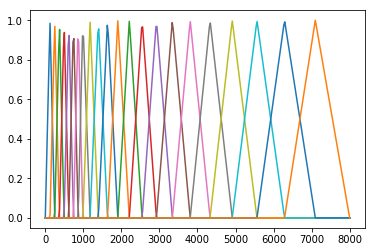

In [19]:
f_range = np.linspace(0, 8000, 320)
for i in range(0, filter_bank.shape[0]):
    plt.plot(f_range, filter_bank[i, ])

- Implement a function to compute the MFCC feature vector of a frame from the Mel filter bank output by using Discrete Fourier Transform
- DCT Function:
<img src='Images/speaker/9_DCT.JPG' width='300'>
- where Y(m) is the output of the Mel Filter Bank, n=0 is the offset and DCT values above n=15 will not be used.
- We only use n from 1 to 15.
<img src='Images/speaker/10_feature_pipeline.JPG' width='450'>
- We need to calculate the power spectrum for the input frames using Discrete Fourier Transform (DFT)
#### Power Spectrum calculation
- We have our time domain framed signal $s_i(n)$ where i vary over number of frames and n ranges over number of frame samples, or Frame Length (in our case, N = 320, so n is from 0 to 319).
- First we need to take DFT of $s_i(n)$ to have $S_i(k)$ of each frame i and then evaluate the power spectrum $P_i(k)$ for frame i
<img src='Images/speaker/11_DFT.JPG' width='450'>
- where $h(n)$ is N=320 sample Hamming window and K(=320) is the length of DFT. The windowing is done to minimize the leakage effects after DFT as the frame size is of finite length. The power spectral given by:
<img src='Images/speaker/12_Power.JPG' width='150'>

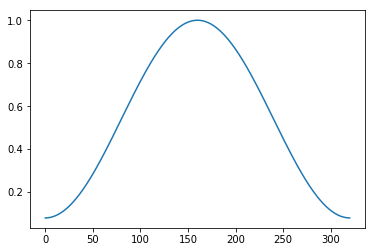

In [20]:
# Hamming window
from scipy import hamming
from scipy.fftpack import fft, dct

plt.plot(np.linspace(0, 320, 320), hamming(320))

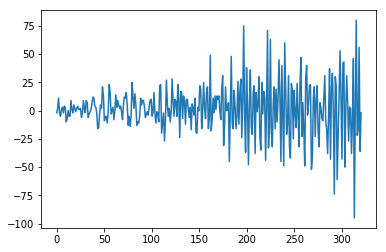

In [21]:
# Voice frame
plt.plot(np.linspace(0, 320, 320), voiced_frames[0])

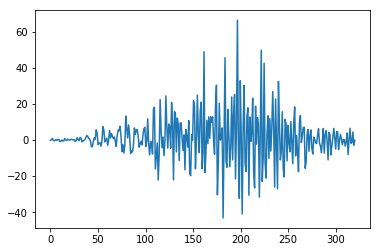

In [22]:
# Vs frame after hamming 
plt.plot(np.linspace(0, 320, 320), voiced_frames[0]*hamming(320))

In [23]:
# Calculate power spectrum
def cal_power_spectrum(voiced_frames, frame_length=320,
                      window='hamming', dft_length=None):
    dft_length = dft_length or frame_length
    if window == 'hamming':
        window = hamming(frame_length)
    else:
        raise NotImplementedError
    no_frames = voiced_frames.shape[0]
    power_spectrum = np.zeros((no_frames , dft_length))
    for i in range(0, no_frames):
        frame = voiced_frames[i, ]
        frame = frame * window # Using hamming window
        # Perform DCT
        dct_frame = abs(fft(frame, n=512))
        dct_frame = dct_frame[:dft_length]
        power_spec = dct_frame ** 2 / frame_length
        power_spectrum[i, ] = power_spec
    return power_spectrum
        
    

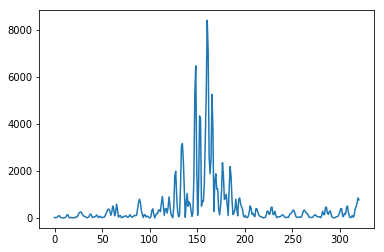

In [24]:
x = np.linspace(0, 320, 320)
plt.plot(x, cal_power_spectrum(voiced_frames)[1])

In [25]:
# Apply Mel Filter Bank to the power spectrum
# full filter bank
power_spectrum = cal_power_spectrum(voiced_frames)
fil_to_spec = np.dot(filter_bank, power_spectrum[1])
fil_to_spec.shape

(22,)

In [26]:
def extract_features(filter_bank_energy, power_spectrum, n=15):
    feature_vector = np.zeros((power_spectrum.shape[0], n))
    for i in range(0, power_spectrum.shape[0]):
        # Compute energy filter bank of the power spectrum of a frame
        feature_temp = np.dot(filter_bank, power_spectrum[i])
        # If feature is zero, we get problems with log, so remove
        feature_temp = np.where(feature_temp==0, np.finfo(float).eps,
                               feature_temp)
        # Take log
        feature_temp = np.log10(feature_temp)
        # Take DCT, so it will give us 22 (number of filters) 
        # cepstral coefficients
        feature_temp = dct(feature_temp)
        # Only take 15 coefficients from 1 to 15
        feature_temp = feature_temp[1:16]
        # This is called the Mel Frequency Cepstral Coefficients
        feature_vector[i, ] = feature_temp
    return feature_vector

In [27]:
# Getting MFCCs:
feature_vector = extract_features(filter_bank, power_spectrum)

### Probabilistic Model of Speech
- For each speaker, a Naive Gaussian Mixture Model (GMM) can be used to form a statistical model the MFCCs. 
- Naive: GMM has only diagonal covariance matrices.
<img src='Images/speaker/13_pdf_gmm.JPG' width='200'>
- Where x is the DCT function of the MFCC feature vector.
- $\mu_k$ is the mean
- $C_k$ is the covariance matrix
- K is the modes of GMM with $\lambda$
- Gaussian normal distribution for the general D-dimensional case:
<img src='Images/speaker/14_d_gaussian.JPG' width='250'>
- The weights have to satisfy the condition:
$$\sum_{k=1}^{K}{w_k} = 1$$
- Every speaker is described by on GMM $\lambda = \{w_k, \mu_k, C_k\}$. Those parameters have to be estimated with a training algorithm from the training data of the specific speaker.
#### Universal Background model
- To reduce the amount of training data and the computational cost for training, a Universal Background Model (UBM) can be used which is pretrained on large dataset.
- Good speaker models require a huge amount of training data such that the GMM parameters can be estimated as accurately as possible. But a speaker who wants to enroll into the system normally does not want to speak for more than a few seconds.
- So if we want to have a good speaker model with **little** training data, we need a general speaker model or Universal Background Model (UBM) is often used. 
- Idea: all speakers have certain similarities (common features). The individual speaker models can be derived from the **general** speaker model and some specific features of that speaker from training data. 
- UBM is only trained once with a huge amount of training data, and then used as a parameter initialization for the training of the speaker models.
- Naive GMM-UBM:
$$p_{UBM}(x) = \sum_{k=1}^{K}{\omega_{UBM,k} * p(x|\mu_{UBM,k}, C_{UBM,k})}$$
- Those parameters are estimated from the UBM training data.
- UBM used in this Lab is already trained from the training set of 462 speakers of the TIMIT database. UBM consists of K=49 naive Gaussian modes (diagonal covariance matrices) in a D=15 dimensional feature space.

#### Speaker models adaption
- The GMM spekear model for a particular speaker with his training data $X=\{x_1, x_2, ... , x_t, ... x_T\}$ adapted from the UBM-GMM equation above by modifying the parameters $\{\omega_{UBM,k}, \mu_{UBM,k}, C_{UBM,k}\}$. Therefore, we first calculate the posteriori probability of $x_t$ belongting to the k-th mode of the UBM-GMM by using the Bayes theorem

In [28]:
# Read UBM file:
ubm = loadmat('forStudents/ubm/UBM_GMMNaive_MFCC_Spectrum0to8000Hz.mat')

#### UBM file information:
Documentation for UBM data structure:

The file 'UBM_GMMNaive_MFCC_Spectrum0to8000Hz.mat' contains four variables:

> 'K':
   Number of mixture components in the GMM.

> 'D':
   Dimension of the gaussian normal distribution.

> 'means':
   A 'K' times 'D' dimensional double array, containing the means.

> 'var':
   A 'K' times 'D' dimensional double array, containing the diagonal elements of the covariance matrices.

> 'weights':
   A vector of size 'K' containing the weights for the individual mixture components.

In [29]:
no_mix_component = ubm['K']

In [30]:
gauss_dim = ubm['D']

In [31]:
mean_mat = ubm['means']

In [32]:
covarience_mat = ubm['var']

In [33]:
weight_mat = ubm['weights']

In [34]:
mean_mat.shape

(49, 15)

In [35]:
covarience_mat.shape

(49, 15)

In [36]:
weight_mat.shape

(1, 49)

K = 49 Gaussian mode

D = 15 Dimensional feature vector space


In [37]:
feature_vector.shape

(308, 15)

- To calculate posteriori probability, we first need the maximum likelihood function:
$$p(x_t|\mu_{UBM,k}, C_{UBM,k})$$
... using multivariate normal distribution pdf

In [38]:
from scipy.stats import multivariate_normal

def gaussian_ml_mvn(feature_vector, mean_mat, covarience_mat,
                   num_mode=49):
    N = feature_vector.shape[0] # Number of frames
    # Maximum likelihood matrix will have N rows for N frames, 
    # and K columns for K mode
    ml_mat = np.zeros((N, num_mode)) 
    for i in range(0, num_mode):
        mean = mean_mat[i, ]
        cov_mat = covarience_mat[i, ]
        mvn = multivariate_normal(mean=mean, cov=cov_mat)
        ml_mat[:, i] = mvn.pdf(feature_vector)
    return ml_mat

In [39]:
ml_mat = gaussian_ml_mvn(feature_vector, mean_mat, covarience_mat)
ml_mat.shape

(308, 49)

- Next we need to calculate the evidence for all the frames
$$p_{UBM}(x) = \sum_{k=1}^{K=49}{\omega_{UBM,k} p(x|\mu_{UBM,k}, C_{UBM,k})}$$

In [40]:
def cal_evidence_mat(feature_vector, ml_mat, weight_mat, 
                     num_mode=49):
    N = feature_vector.shape[0]
    evidence_mat = np.zeros((N, 1))
    for i in range(0, N):
        evidence = np.dot(weight_mat, ml_mat[i])
        evidence_mat[i,] = evidence
#     weight_mat = np.matlib.repmat(weight_mat, N, 1)
#     evidence_mat = np.dot(weight_mat, ml_mat)
    return evidence_mat

In [41]:
evidence_mat = cal_evidence_mat(feature_vector, ml_mat, weight_mat)

In [42]:
evidence_mat.shape

(308, 1)

In [43]:
def cal_posteriori_mat(feature_vector, ml_mat, evidence_mat, 
                       weight_mat, num_mode=49):
    N = feature_vector.shape[0]
    posteriori_mat = np.zeros((N, num_mode))
    for j in range(0, N):
        posteriori = weight_mat * ml_mat[j, ] / evidence_mat[j] 
        posteriori_mat[j, ] = posteriori
    return posteriori_mat

In [44]:
posteriori_mat = cal_posteriori_mat(feature_vector, ml_mat,
                                   evidence_mat, weight_mat)

In [45]:
# We see that shape is 260, 49; So if we use matrix-wise operator
# we can shorten the amount of calculation time (avoiding for loops)
posteriori_mat.shape


(308, 49)

In [46]:
def cal_posteriori_mat_opt(feature_vector, ml_mat, evidence_mat, 
                       weight_mat, num_mode=49):
    N = feature_vector.shape[0]
    # Repeat the weight_mat N times to form new weight_mat 
    #(N x 49) shape
    weight_mat = repmat(weight_mat, N, 1) 
    posteriori_mat = (weight_mat * ml_mat) / evidence_mat
    return posteriori_mat

In [47]:
posteriori_mat_opt = cal_posteriori_mat_opt(feature_vector, 
                                           ml_mat, evidence_mat,
                                           weight_mat)

In [48]:
# Understanding matrix operation
a = np.array([[2, 3, 4],[3, 4, 5]])
b = np.array([[1,3, 5], [3, 2, 1]])
c = np.array([2, 3, 4])
a * b / c

array([[ 1.        ,  3.        ,  5.        ],
       [ 4.5       ,  2.66666667,  1.25      ]])

### Speaker Model Adaption
- With the posteriori calculated above $P(k|x_t)$ and the training data $X$, the expectation value $\mu$ and the covariance matrix $C$ of the new speaker model can be calculated.
- First, we need to calculate the weighting of the UBM to the training data:
$$n_k = \sum_{t=1}^{T}{P(k|x_t)}$$
- where T is the number of frames fragmented from the original audio frame, k is the k-th Gaussian mode (k = 1... 49) in this case
- And then we can calculate the $\alpha_k$:
$$\alpha_k = \frac{n_k}{n_k + r}$$
- where r is the relevance factor that can be chosen freely. Smaler r reduces the influence of the speaker specific training data and increases the weighting of the UBM.
- Then we calculate the expectation value $\hat{\mu}_i$ for the training data $X$:
$$\hat{\mu}_k(X) = \frac{1}{n_k}\sum_{t=1}^{T}P(k|x_t)x_t$$
- With the factor $\alpha_i$, the expectation factor for the new speaker model can be computed:
$$\mu_k = \alpha_k\hat{\mu}_k + (1-\alpha_k)\mu_{k, UBM}$$
- The expectation then can be used to calculate the relation matrix $\hat{C}_k$:
$$\hat{C}_k = \frac{1}{n_k}\sum_{t=1}^{T}P(k|x_t)x_tx_t^T - \hat{\mu}_k\hat{\mu}_k^T $$
- The corresponding weight of the k-th mode:
$$\hat{\omega}_k = \frac{1}{T}\sum_{t=1}^{T}p(k|x_t)$$
- with
$$\sum_{k=1}^{K}\hat{\omega}_k=1$$
- Now we create the Adaption model for the speaker using k-th mode of the UBM and all the "hat" parameters above to calculate the parameters of the k-th mode of the Speaker model:
$$\mu_k = \alpha_k\hat{\mu}_k + (1 - \alpha_k)\mu_{UBM,k}$$
$$C_k = \alpha_k\hat{C}_k + (1 - \alpha_k)C_{UBM,k}$$
$$\omega_k = \alpha_k\hat{\omega}_k + (1 - \alpha_k)\omega_{UBM,k}$$

In [49]:
posteriori_mat.shape

(308, 49)

In [50]:
feature_vector.shape

(308, 15)

In [51]:
# Calculate weighting of the UBM to current training data
# UBM is the general speaker model, now we find the relationship
# with the current training speaker: n_k
def cal_specific_weight(posteriori_mat, K=49):
    n = np.zeros((K, 1))
    for i in range(0, K):
        n[i] = posteriori_mat[:, i].sum()
    return n

In [52]:
n = cal_specific_weight(posteriori_mat)
n.shape

(49, 1)

In [53]:
# Calculate all the "hat" parameters:
def cal_hat_parameters(n, feature_vector, posteriori_mat):
    num_mode = posteriori_mat.shape[1]
    D = feature_vector.shape[1]
    no_frames = feature_vector.shape[0]
    mu_hat = np.zeros((num_mode, D))
    C_hat = np.zeros((num_mode, D))
    omega_hat = n / no_frames # Shape (num_mode, 1)
    for k in range(0, num_mode):
        n_k = n[k]
        temp_pos = repmat(posteriori_mat[:, k], D, 1)
        temp_mu = temp_pos.T * feature_vector
        mu_hat[k, ] = 1 / n_k * np.sum(temp_mu, axis=0)
        temp_C = temp_pos.T * feature_vector**2
        temp_C = 1 / n_k * np.sum(temp_C, axis=0)
        C_hat[k, ] = temp_C - mu_hat[k,]**2
        
    return mu_hat, C_hat, omega_hat

In [54]:
mu_hat, C_hat, omega_hat = cal_hat_parameters(n,feature_vector, posteriori_mat)


In [63]:
def cal_speaker_model_parameters(mu_hat, C_hat, omega_hat,
                                 mu_ubm, C_ubm, omega_ubm,
                                 n, r=0.1):
    alpha = n / (n + r) # Shape: (49, 1)
    alpha_rep = repmat(alpha, 1, 15)
    mu = alpha_rep * mu_hat + (1 - alpha_rep) * mu_ubm
    C = alpha_rep * C_hat + (1 - alpha_rep) * C_ubm
    omega = alpha * omega_hat + (1 - alpha) * omega_ubm.T
    return mu, C, omega.T

In [64]:
mu, C, omega = cal_speaker_model_parameters(mu_hat, C_hat, omega_hat,
                                           mean_mat, covarience_mat,
                                           weight_mat, n)

### Speaker Identification
- Now we have the new mean ($\mu$), covarience matrix ($C$), weight ($\omega$), we call these parameters $\lambda$ of the model for a specific speaker. They are created using training data, so we have to include the speaker name (folder name) in the model.
- After all the training model are applied, we will use test data for testing, and the speaker decision will be made using maximum likelihood, or maximum a posteriori
$$log P(X|\lambda) = \sum_{t=1}^{T}logp(x_t|\lambda)$$
- and taking the speaker of the most likely model:
$$\hat{s} = argmax(logP(X|\lambda))$$

In [65]:
# Create training models:
import glob

In [66]:
all_training_folders = glob.glob("forStudents/timit/train/*/*")
user_name = []
wav_file = []
no_user = len(all_training_folders)
for i in all_training_folders:
    user_name.append(os.path.basename(i))
    wav_file.append(glob.glob(i + '/*.wav'))
    
all_test_folders = glob.glob("forStudents/timit/test/*/*")
user_name_test = []
wav_file_test = []
for i in all_test_folders:
    user_name_test.append(os.path.basename(i))
    wav_file_test.append(glob.glob(i + '/*.wav'))
no_test_user = len(all_test_folders)

In [67]:
no_test_user

170

In [68]:
# Read UBM files
# Read UBM file:
ubm = loadmat('forStudents/ubm/UBM_GMMNaive_MFCC_Spectrum0to8000Hz.mat')
ubm_mean = ubm['means']
ubm_weight = ubm['weights']
ubm_var = ubm['var']

In [147]:
# Train all speakers using the TEST set!
frame_list = []
speaker_model = []
mel_fbank = mel_filter_bank(no_filters=22)
for i, wav_list in enumerate(wav_file_test):
    init=0
    for k in wav_list[0:9]:
        data_temp = wavfile.read(k)
        # Segment all wave files to small frames
        frame_matrix, no_frame = frame_segment(data_temp[1])
        # We need to detect voice activity
        frame_matrix = frames_with_voice(frame_matrix,
                                        gamma=17)
        if init==0:
            frame_temp = frame_matrix
            init += 1
        else:
            frame_temp = np.vstack((frame_temp, frame_matrix))
    # Now frame_temp is the frame matrix of each user, we 
    # will use it for training the model:
    # First, we need to calculate power spectrum of the
    # voiced frames:
    power_spectrum = cal_power_spectrum(frame_temp,
                                       frame_length=320)
    # Then, we need to apply the mel_fbank to the power
    # spectrum to extract the feature vector:
    feature_vector = extract_features(mel_fbank, 
                                     power_spectrum)
    # Next, we need to calculate the likelihood:
    ml_mat = gaussian_ml_mvn(feature_vector, ubm_mean,
                            ubm_var)
    # Then, we calculate the evidence matrix:
    evidence_mat = cal_evidence_mat(feature_vector,
                                   ml_mat, ubm_weight)
    # Now, we calculate the posteriori matrix:
    posteriori_mat = cal_posteriori_mat_opt(feature_vector,
                                           ml_mat,
                                           evidence_mat,
                                           ubm_weight)
    # Calculate n: specific weight
    n = cal_specific_weight(posteriori_mat, K=49)
    # Calculate hat parameters:
    mu_hat, C_hat, omega_hat = cal_hat_parameters(n, 
                                                 feature_vector,
                                                 posteriori_mat)
    # Finally, calculate speaker model:
    mu, C, omega = cal_speaker_model_parameters(mu_hat,
                                                C_hat,
                                                omega_hat,
                                                ubm_mean,
                                                ubm_var,
                                                ubm_weight,
                                                n, r=0.1)
    speaker_model.append([mu, C, omega])
        

In [148]:
feature_vector_list = []
for i, wav_list in enumerate(wav_file_test):
    init=0
    k = wav_list[9]
    data_temp = wavfile.read(k)
    # Segment all wave files to small frames
    frame_matrix, no_frame = frame_segment(data_temp[1])
    # We need to detect voice activity
    frame_matrix = frames_with_voice(frame_matrix,
                                    gamma=17)
    if init==0:
        frame_temp = frame_matrix
        init += 1
    else:
        frame_temp = np.vstack((frame_temp, frame_matrix))
    # Now frame_temp is the frame matrix of each user, we 
    # will use it for training the model:
    # First, we need to calculate power spectrum of the
    # voiced frames:
    power_spectrum = cal_power_spectrum(frame_temp,
                                       frame_length=320)
    # Then, we need to apply the mel_fbank to the power
    # spectrum to extract the feature vector:
    feature_vector = extract_features(mel_fbank, 
                                     power_spectrum)
    feature_vector_list.append(feature_vector)

In [149]:
import operator
def predict_using_map(speaker_model, feature_vector):
    evidence_list = []
    for i, model in enumerate(speaker_model):  
        mu, C, omega = model
        ml_mat = gaussian_ml_mvn(feature_vector, mu, C)
        evidence_mat = cal_evidence_mat(feature_vector, 
                                        ml_mat, omega)
        evidence_mat = np.log(evidence_mat)
        evidence_list.append(evidence_mat.sum())
    index, value = max(enumerate(evidence_list),
                      key=operator.itemgetter(1))
    return index, value
        
        

In [156]:
index, value = predict_using_map(speaker_model, feature_vector_list[15])

In [157]:
user_name_test[index]

'fjwb0'

In [158]:
index

15